# Intro

This notebook is my attempt on the https://www.kaggle.com/c/cat-in-the-dat challenge.


The purpose of this challenge is to Encode categorical data in a most appropriate way for a certain classifer. There are categorical features with different type of cardinality, ordinality and cyclicity. 

I applied different techniques such as:
    - Ordinal label encoding
    - Binary encoding (get_dummies)
    - Hash tricks
    - Encoding based on mean target value
    - Encoding based on alphabetical order of strings

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None, 'display.max_rows', 100)

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.shape, test.shape

((300000, 25), (200000, 24))

# EDA

In [106]:
train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [107]:
# Check for empty cells
test.isnull().sum()

id       0
bin_0    0
bin_1    0
bin_2    0
bin_3    0
bin_4    0
nom_0    0
nom_1    0
nom_2    0
nom_3    0
nom_4    0
nom_5    0
nom_6    0
nom_7    0
nom_8    0
nom_9    0
ord_0    0
ord_1    0
ord_2    0
ord_3    0
ord_4    0
ord_5    0
day      0
month    0
dtype: int64

In [108]:
# Check value types
test.dtypes.value_counts()

object    17
int64      7
dtype: int64

In [109]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 25 columns):
id        300000 non-null int64
bin_0     300000 non-null int64
bin_1     300000 non-null int64
bin_2     300000 non-null int64
bin_3     300000 non-null object
bin_4     300000 non-null object
nom_0     300000 non-null object
nom_1     300000 non-null object
nom_2     300000 non-null object
nom_3     300000 non-null object
nom_4     300000 non-null object
nom_5     300000 non-null object
nom_6     300000 non-null object
nom_7     300000 non-null object
nom_8     300000 non-null object
nom_9     300000 non-null object
ord_0     300000 non-null int64
ord_1     300000 non-null object
ord_2     300000 non-null object
ord_3     300000 non-null object
ord_4     300000 non-null object
ord_5     300000 non-null object
day       300000 non-null int64
month     300000 non-null int64
target    300000 non-null int64
dtypes: int64(8), object(17)
memory usage: 57.2+ MB


In [110]:
# Creating lists for each dataype
categorical = [var for var in train.columns if train[var].dtype == 'O']
discrete = [var for var in train.columns if train[var].dtype != 'O' and train[var].nunique() < 20]
continuous = [var for var in train.columns if train[var].dtype != 'O' and var not in discrete and var != 'SalePrice']

print('Categorical variables are {}'.format(len(categorical)))
print(categorical)
print('')
print('Discrete variables are {}'.format(len(discrete)))
print(discrete)
print('')
print('Continuous variables are {}'.format(len(continuous)))
print(continuous)
print('')

Categorical variables are 17
['bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5']

Discrete variables are 7
['bin_0', 'bin_1', 'bin_2', 'ord_0', 'day', 'month', 'target']

Continuous variables are 1
['id']



In [111]:
# Check for cardinality 
for var in train.columns:
    print('')
    print(var)
    print(train[var].value_counts()/train.shape[0])


id
2047      0.000003
107105    0.000003
8785      0.000003
14930     0.000003
12883     0.000003
            ...   
5544      0.000003
7593      0.000003
1450      0.000003
3499      0.000003
0         0.000003
Name: id, Length: 300000, dtype: float64

bin_0
0    0.872497
1    0.127503
Name: bin_0, dtype: float64

bin_1
0    0.743393
1    0.256607
Name: bin_1, dtype: float64

bin_2
0    0.616777
1    0.383223
Name: bin_2, dtype: float64

bin_3
T    0.511783
F    0.488217
Name: bin_3, dtype: float64

bin_4
Y    0.638777
N    0.361223
Name: bin_4, dtype: float64

nom_0
Green    0.424470
Blue     0.320553
Red      0.254977
Name: nom_0, dtype: float64

nom_1
Trapezoid    0.337270
Square       0.165323
Star         0.153013
Circle       0.124400
Polygon      0.120477
Triangle     0.099517
Name: nom_1, dtype: float64

nom_2
Lion       0.337650
Cat        0.165530
Snake      0.153263
Dog        0.124813
Axolotl    0.120453
Hamster    0.098290
Name: nom_2, dtype: float64

nom_3
Russia       

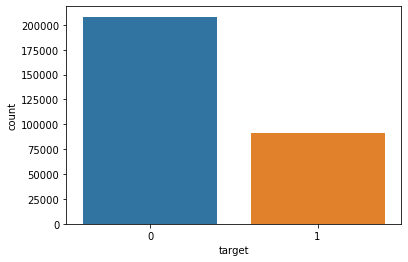

In [112]:
#Exploring the balance of the Target variable
sns.countplot(train['target'])

In [113]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(train, 0.90)
print('correlated features: ', len(set(corr_features)) )
print(corr_features)

correlated features:  0
set()


In [114]:
for var in categorical:
    print(train.groupby(var)[var].count() / len(train))
    print()

bin_3
F    0.488217
T    0.511783
Name: bin_3, dtype: float64

bin_4
N    0.361223
Y    0.638777
Name: bin_4, dtype: float64

nom_0
Blue     0.320553
Green    0.424470
Red      0.254977
Name: nom_0, dtype: float64

nom_1
Circle       0.124400
Polygon      0.120477
Square       0.165323
Star         0.153013
Trapezoid    0.337270
Triangle     0.099517
Name: nom_1, dtype: float64

nom_2
Axolotl    0.120453
Cat        0.165530
Dog        0.124813
Hamster    0.098290
Lion       0.337650
Snake      0.153263
Name: nom_2, dtype: float64

nom_3
Canada        0.166503
China         0.153480
Costa Rica    0.119960
Finland       0.123140
India         0.099840
Russia        0.337077
Name: nom_3, dtype: float64

nom_4
Bassoon     0.228160
Oboe        0.307643
Piano       0.281723
Theremin    0.182473
Name: nom_4, dtype: float64

nom_5
005dd4ce3    0.000903
037bd73d8    0.004677
05950689f    0.006620
05d5943a3    0.001903
06eeaf0aa    0.009167
               ...   
f8faea16f    0.004613
f9d17bb93  

bin_3


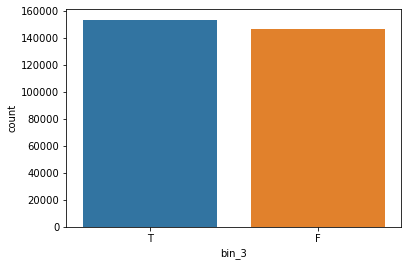

bin_4


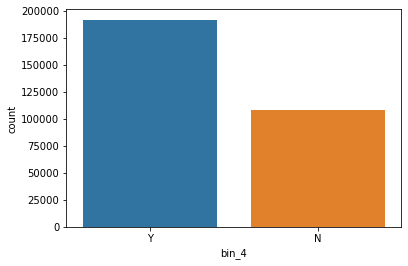

nom_0


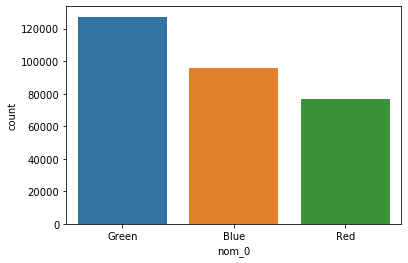

nom_1


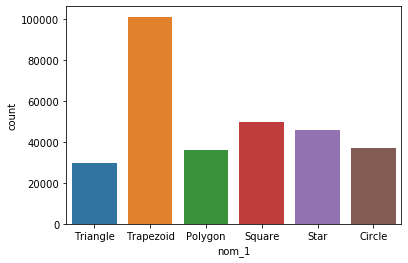

nom_2


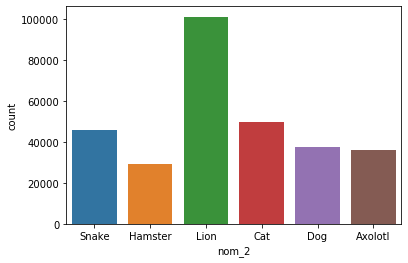

nom_3


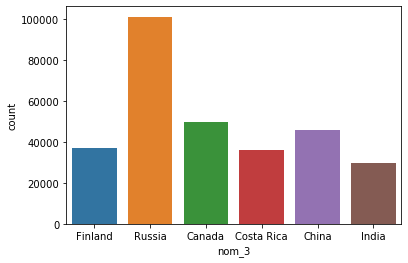

nom_4


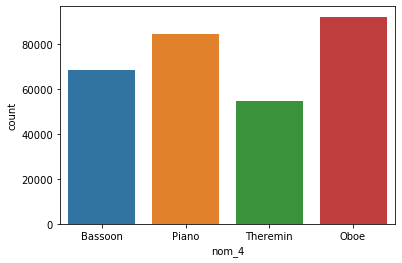

nom_5


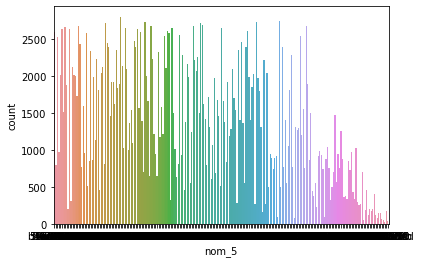

nom_6


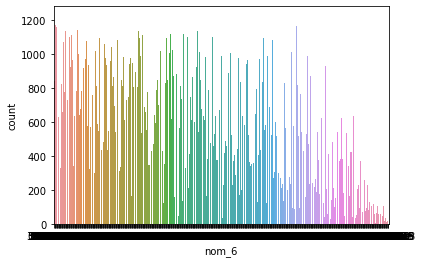

nom_7


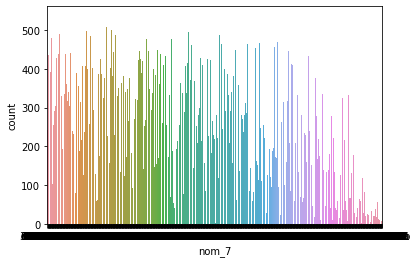

nom_8


KeyboardInterrupt: 

In [115]:
for var in categorical:
    print(var)
    sns.countplot(train[var])
    plt.show()

# Variable encoding

In [3]:
# First a train test split
from sklearn.model_selection import train_test_split
X_train, X_dev, y_train, y_dev = train_test_split(train.iloc[:,:-1], train.iloc[:,-1], test_size = 0.1)

In [4]:
X_train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
29275,29275,1,0,0,F,Y,Red,Trapezoid,Lion,Costa Rica,Bassoon,1e6cb96e8,73d7ca889,659c782a1,075c68fbd,9f2dec0b7,1,Novice,Freezing,f,G,ac,2,2
253016,253016,0,0,0,T,N,Green,Circle,Lion,Russia,Theremin,5d18641ff,395941181,fcceb793d,afea2dab3,aa6a31d6f,3,Novice,Cold,f,A,ri,5,2
195082,195082,1,0,1,T,N,Blue,Trapezoid,Snake,Finland,Piano,116f7e3e2,3c1c64eaa,82598a462,e6e22d99b,c0fa98ac1,1,Novice,Warm,j,H,be,4,12
250503,250503,1,0,0,T,Y,Blue,Trapezoid,Dog,Finland,Oboe,493de6347,395941181,d12022685,497cd3de8,0496c2132,3,Grandmaster,Lava Hot,h,G,Eg,2,11
69095,69095,0,0,1,F,Y,Red,Trapezoid,Cat,Finland,Piano,924346656,d405aebc1,cab0b4ca9,8b7aab9f1,bed2b6c77,2,Master,Boiling Hot,o,Y,ek,1,10


## Binary encoding

In [5]:
binary = [var for var in train.columns if train[var].nunique() < 3 and var!='target']
binary

['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']

In [6]:
X_train[binary] = pd.get_dummies(X_train[binary], drop_first=True)

In [7]:
X_dev[binary] = pd.get_dummies(X_dev[binary], drop_first=True)

In [8]:
test[binary] = pd.get_dummies(X_dev[binary], drop_first=True)

In [9]:
X_train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
29275,29275,1,0,0,0,1,Red,Trapezoid,Lion,Costa Rica,Bassoon,1e6cb96e8,73d7ca889,659c782a1,075c68fbd,9f2dec0b7,1,Novice,Freezing,f,G,ac,2,2
253016,253016,0,0,0,1,0,Green,Circle,Lion,Russia,Theremin,5d18641ff,395941181,fcceb793d,afea2dab3,aa6a31d6f,3,Novice,Cold,f,A,ri,5,2
195082,195082,1,0,1,1,0,Blue,Trapezoid,Snake,Finland,Piano,116f7e3e2,3c1c64eaa,82598a462,e6e22d99b,c0fa98ac1,1,Novice,Warm,j,H,be,4,12
250503,250503,1,0,0,1,1,Blue,Trapezoid,Dog,Finland,Oboe,493de6347,395941181,d12022685,497cd3de8,0496c2132,3,Grandmaster,Lava Hot,h,G,Eg,2,11
69095,69095,0,0,1,0,1,Red,Trapezoid,Cat,Finland,Piano,924346656,d405aebc1,cab0b4ca9,8b7aab9f1,bed2b6c77,2,Master,Boiling Hot,o,Y,ek,1,10


## Encoding variables with low cardinality with no obvious ordinality

In [10]:
low_card = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']

In [11]:
# Covert Strings to numbers
def find_categorical_mappings(df, var, target):
    #generating an ordered list
    ordered_labels=pd.concat((df, y_train), axis=1).groupby([var])[target].mean().sort_values().index
    
    #return the dictionary with mappings
    return {k: i for i, k in enumerate(ordered_labels, 0)}

In [12]:
def integer_encode(train, dev, test, var, ordinal_mapping):
    train[var] = train[var].map(ordinal_mapping)
    dev[var] = dev[var].map(ordinal_mapping)
    test[var] = test[var].map(ordinal_mapping)

In [13]:
#I will transform the categorical features as well as the boolen Missing Indicators
for var in low_card:
    mappings = find_categorical_mappings(X_train, var, 'target')
    integer_encode(X_train, X_dev, test, var, mappings)

In [14]:
# Check how the dataset looks like now
X_train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
29275,29275,1,0,0,0,1,2,1,1,3,0,1e6cb96e8,73d7ca889,659c782a1,075c68fbd,9f2dec0b7,1,Novice,Freezing,f,G,ac,2,2
253016,253016,0,0,0,1,0,1,0,1,1,3,5d18641ff,395941181,fcceb793d,afea2dab3,aa6a31d6f,3,Novice,Cold,f,A,ri,5,2
195082,195082,1,0,1,1,0,0,1,2,0,1,116f7e3e2,3c1c64eaa,82598a462,e6e22d99b,c0fa98ac1,1,Novice,Warm,j,H,be,4,12
250503,250503,1,0,0,1,1,0,1,0,0,2,493de6347,395941181,d12022685,497cd3de8,0496c2132,3,Grandmaster,Lava Hot,h,G,Eg,2,11
69095,69095,0,0,1,0,1,2,1,4,0,1,924346656,d405aebc1,cab0b4ca9,8b7aab9f1,bed2b6c77,2,Master,Boiling Hot,o,Y,ek,1,10


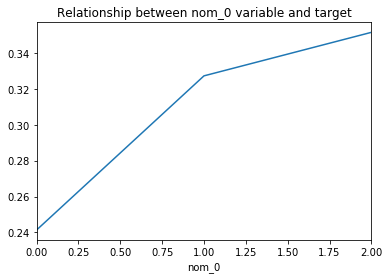

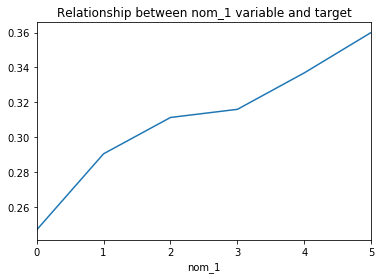

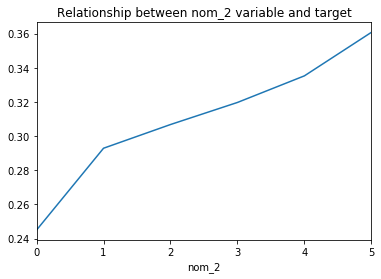

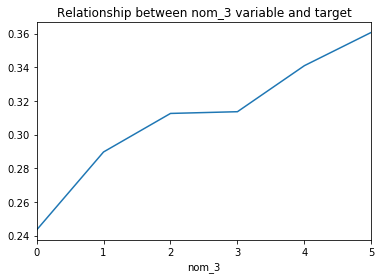

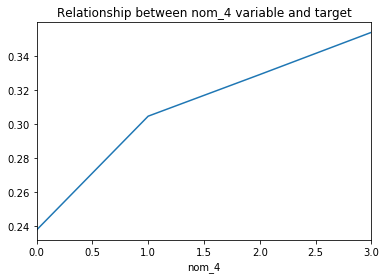

In [15]:
# Explore the realtionship between categorical variabels and the target
i = 0
for var in low_card:
    i = i + 1
    fig = plt.figure()
    fig = pd.concat((X_train, y_train), axis=1).groupby([var])['target'].mean().plot()
    fig.set_title('Relationship between {} variable and target'.format(var))
    fig.set_ylabel = ('Mean Target')
    plt.show()

In [16]:
for var in low_card:
    print(X_train.groupby(var)[var].count() / len(X_train))
    print()

nom_0
0    0.320711
1    0.424574
2    0.254715
Name: nom_0, dtype: float64

nom_1
0    0.124396
1    0.336922
2    0.152737
3    0.120570
4    0.165470
5    0.099904
Name: nom_1, dtype: float64

nom_2
0    0.124715
1    0.337833
2    0.153541
3    0.120426
4    0.165330
5    0.098156
Name: nom_2, dtype: float64

nom_3
0    0.123200
1    0.337611
2    0.153444
3    0.119933
4    0.166274
5    0.099537
Name: nom_3, dtype: float64

nom_4
0    0.228167
1    0.281604
2    0.307619
3    0.182611
Name: nom_4, dtype: float64



In [17]:
X_train.shape, X_dev.shape, test.shape

((270000, 24), (30000, 24), (200000, 24))

## Encoding cyclical data

In [18]:
cyclical_data = ['day', 'month']

In [19]:
train[cyclical_data].nunique()

day       7
month    12
dtype: int64

In [20]:
def date_cyc_enc(df, col, max_vals):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_vals)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_vals)
    return df

In [21]:
for var in cyclical_data:
    X_train = date_cyc_enc(X_train, var, X_train[var].max())
    X_dev = date_cyc_enc(X_dev, var, X_dev[var].max())
    test = date_cyc_enc(test, var, test[var].max())

In [22]:
X_train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,day_sin,day_cos,month_sin,month_cos
29275,29275,1,0,0,0,1,2,1,1,3,0,1e6cb96e8,73d7ca889,659c782a1,075c68fbd,9f2dec0b7,1,Novice,Freezing,f,G,ac,2,2,0.974928,-0.222521,8.660254e-01,0.500000
253016,253016,0,0,0,1,0,1,0,1,1,3,5d18641ff,395941181,fcceb793d,afea2dab3,aa6a31d6f,3,Novice,Cold,f,A,ri,5,2,-0.974928,-0.222521,8.660254e-01,0.500000
195082,195082,1,0,1,1,0,0,1,2,0,1,116f7e3e2,3c1c64eaa,82598a462,e6e22d99b,c0fa98ac1,1,Novice,Warm,j,H,be,4,12,-0.433884,-0.900969,-2.449294e-16,1.000000
250503,250503,1,0,0,1,1,0,1,0,0,2,493de6347,395941181,d12022685,497cd3de8,0496c2132,3,Grandmaster,Lava Hot,h,G,Eg,2,11,0.974928,-0.222521,-5.000000e-01,0.866025
69095,69095,0,0,1,0,1,2,1,4,0,1,924346656,d405aebc1,cab0b4ca9,8b7aab9f1,bed2b6c77,2,Master,Boiling Hot,o,Y,ek,1,10,0.781831,0.623490,-8.660254e-01,0.500000


## Encoding ordinal data with low cardinality

In [23]:
train['ord_4'].nunique()

26

In [24]:
ord_low_card = ['ord_0', 'ord_1', 'ord_2', 'ord_3']

In [25]:
ord_high_card = ['ord_4', 'ord_5']

In [26]:
# Importing categorical options of pandas
from pandas.api.types import CategoricalDtype 

# seting the orders of our ordinal features
ord_1 = CategoricalDtype(categories=['Novice', 'Contributor','Expert', 
                                     'Master', 'Grandmaster'], ordered=True)
ord_2 = CategoricalDtype(categories=['Freezing', 'Cold', 'Warm', 'Hot',
                                     'Boiling Hot', 'Lava Hot'], ordered=True)
ord_3 = CategoricalDtype(categories=['a', 'b', 'c', 'd', 'e', 'f', 'g',
                                     'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o'], ordered=True)
ord_4 = CategoricalDtype(categories=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
                                     'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
                                     'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], ordered=True)

In [27]:
X_train.ord_3.head(10)

29275     f
253016    f
195082    j
250503    h
69095     o
23111     b
234758    g
74705     k
115395    a
102003    a
Name: ord_3, dtype: object

In [28]:
# Transforming ordinal Features
X_train.ord_1 = X_train.ord_1.astype(ord_1)
X_train.ord_2 = X_train.ord_2.astype(ord_2)
X_train.ord_3 = X_train.ord_3.astype(ord_3)
X_train.ord_4 = X_train.ord_4.astype(ord_4)

# dev dataset
X_dev.ord_1 = X_dev.ord_1.astype(ord_1)
X_dev.ord_2 = X_dev.ord_2.astype(ord_2)
X_dev.ord_3 = X_dev.ord_3.astype(ord_3)
X_dev.ord_4 = X_dev.ord_4.astype(ord_4)

# test dataset
test.ord_1 = test.ord_1.astype(ord_1)
test.ord_2 = test.ord_2.astype(ord_2)
test.ord_3 = test.ord_3.astype(ord_3)
test.ord_4 = test.ord_4.astype(ord_4)

In [29]:
X_train.ord_3.head(10)

79732     j
87859     e
251964    e
279996    l
292845    a
41278     e
114116    a
95915     l
259211    j
275331    a
Name: ord_3, dtype: category
Categories (15, object): [a < b < c < d ... l < m < n < o]

In [30]:
X_train.ord_3.cat.codes.head(10)

79732      9
87859      4
251964     4
279996    11
292845     0
41278      4
114116     0
95915     11
259211     9
275331     0
dtype: int8

In [31]:
X_train.ord_2.head(10)

79732     Lava Hot
87859     Lava Hot
251964    Freezing
279996        Warm
292845        Cold
41278     Freezing
114116    Freezing
95915     Freezing
259211    Lava Hot
275331    Freezing
Name: ord_2, dtype: category
Categories (6, object): [Freezing < Cold < Warm < Hot < Boiling Hot < Lava Hot]

In [32]:
X_train.ord_2.cat.codes.head(10)

79732     5
87859     5
251964    0
279996    2
292845    1
41278     0
114116    0
95915     0
259211    5
275331    0
dtype: int8

In [29]:
# Geting the codes of ordinal categoy's - train
X_train.ord_1 = X_train.ord_1.cat.codes
X_train.ord_2 = X_train.ord_2.cat.codes
X_train.ord_3 = X_train.ord_3.cat.codes
X_train.ord_4 = X_train.ord_4.cat.codes

# Geting the codes of ordinal categoy's - dev
X_dev.ord_1 = X_dev.ord_1.cat.codes
X_dev.ord_2 = X_dev.ord_2.cat.codes
X_dev.ord_3 = X_dev.ord_3.cat.codes
X_dev.ord_4 = X_dev.ord_4.cat.codes

# Geting the codes of ordinal categoy's - test
test.ord_1 = test.ord_1.cat.codes
test.ord_2 = test.ord_2.cat.codes
test.ord_3 = test.ord_3.cat.codes
test.ord_4 = test.ord_4.cat.codes

In [34]:
for var in ['ord_0', 'ord_1', 'ord_2', 'ord_3','ord_4', 'ord_5']:
    print(var)
    print(X_train[var].nunique())

ord_0
3
ord_1
5
ord_2
6
ord_3
15
ord_4
26
ord_5
192


In [35]:
X_train[['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5']].head(10)

,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5
79732,2,1,5,9,11,lF
87859,3,0,5,4,0,aP
251964,1,4,0,4,14,GJ
279996,3,0,2,11,23,od
292845,2,4,1,0,18,aM
41278,3,2,0,4,25,oG
114116,1,4,0,0,4,Jc
95915,2,0,0,11,25,Wc
259211,1,0,5,9,18,Qh
275331,3,4,0,0,13,aO


In [36]:
X_train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,day_sin,day_cos,month_sin,month_cos
79732,79732,0,1,0,1,1,1,1,1,1,2,17a3709ae,339c0fa05,83c9b6ebc,3bd05fe23,df8ae97cb,2,1,5,9,11,lF,7,1,-2.449294e-16,1.000000,0.500000,8.660254e-01
87859,87859,0,0,1,0,0,1,1,2,4,1,f50eb07ae,b639793f9,a6b411798,5b5c13311,3742db788,3,0,5,4,0,aP,2,9,9.749279e-01,-0.222521,-1.000000,-1.836970e-16
251964,251964,0,0,0,0,0,1,1,4,1,1,30a530eab,d804d7926,0406d6252,802f05fb1,0d3e3e42d,1,4,0,4,14,GJ,3,7,4.338837e-01,-0.900969,-0.500000,-8.660254e-01
279996,279996,0,0,0,0,1,1,1,3,5,1,2ff007c26,90ba6c9a6,4177c067d,3b34e4268,3bd7877b6,3,0,2,11,23,od,4,10,-4.338837e-01,-0.900969,-0.866025,5.000000e-01
292845,292845,1,1,1,1,1,0,1,4,1,2,416a8f3ab,d213f48ed,a85d5428c,3d7700f42,c18567bad,2,4,1,0,18,aM,2,5,9.749279e-01,-0.222521,0.500000,-8.660254e-01


## Encoding ordinal data with high cardinality

In [38]:
# import string
# # Option 2: Join the indices of two letters in string.ascii_letters
# X_train['ord_5_oe_join'] = X_train['ord_5'].apply(lambda x:float(''.join(str(string.ascii_letters.find(letter)+1)
#                                                                            for letter in x)))
# X_dev['ord_5_oe_join'] = X_dev['ord_5'].apply(lambda x:float(''.join(str(string.ascii_letters.find(letter)+1)
#                                                                          for letter in x)))

In [30]:
import string
# Option 3: Split 'ord_5' into two new columns using the indices of two letters in string.ascii_letters, separately
X_train['ord_5_oe1'] = X_train['ord_5'].apply(lambda x:(string.ascii_letters.find(x[0])+1))
X_dev['ord_5_oe1'] = X_dev['ord_5'].apply(lambda x:(string.ascii_letters.find(x[0])+1))
test['ord_5_oe1'] = test['ord_5'].apply(lambda x:(string.ascii_letters.find(x[0])+1))

X_train['ord_5_oe2'] = X_train['ord_5'].apply(lambda x:(string.ascii_letters.find(x[1])+1))
X_dev['ord_5_oe2'] = X_dev['ord_5'].apply(lambda x:(string.ascii_letters.find(x[1])+1))
test['ord_5_oe2'] = test['ord_5'].apply(lambda x:(string.ascii_letters.find(x[1])+1))

In [43]:
X_train[['ord_5', 'ord_5_oe1', 'ord_5_oe2']]

,ord_5,ord_5_oe1,ord_5_oe2
79732,lF,12,32
87859,aP,1,42
251964,GJ,33,36
279996,od,15,4
292845,aM,1,39
...,...,...,...
41670,hh,8,8
68421,Qh,43,8
192922,dZ,4,52
77320,GD,33,30


## Encoding Nominal Features - High Cardinality Features

In [31]:
high_card_feats = ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']

In [47]:
resumetable(X_train[high_card_feats])

Dataset Shape: (270000, 5)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,nom_5,object,0,222,50f116bcf,b3b4d25d0,3263bdce5,7.49
1,nom_6,object,0,522,3ac1b8814,fbcb50fc1,0922e3cb8,8.74
2,nom_7,object,0,1220,68f6ad3e9,3b6dd5612,a6a36f527,9.98
3,nom_8,object,0,2214,c389000ab,4cd920251,de9c9f684,10.83
4,nom_9,object,0,11959,2f4cb3d51,f83c56c21,ae6800dd0,13.26


### Hash Trick (Feature Hash)

In [32]:
for col in high_card_feats:
    X_train[f'hash_{col}'] = X_train[col].apply( lambda x: hash(str(x)) % 5000 )
    X_dev[f'hash_{col}'] = X_dev[col].apply( lambda x: hash(str(x)) % 5000 )
    test[f'hash_{col}'] = test[col].apply( lambda x: hash(str(x)) % 5000 )

In [49]:
resumetable(X_train[['hash_nom_5', 'hash_nom_6', 'hash_nom_7', 'hash_nom_8', 'hash_nom_9']])

Dataset Shape: (270000, 5)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,hash_nom_5,int64,0,218,1772,2146,3341,7.46
1,hash_nom_6,int64,0,499,4787,734,2712,8.67
2,hash_nom_7,int64,0,1058,2280,1526,1842,9.74
3,hash_nom_8,int64,0,1811,2882,1064,3991,10.50
4,hash_nom_9,int64,0,4526,4130,2996,97,11.84


In [50]:
X_train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,day_sin,day_cos,month_sin,month_cos,ord_5_oe_join,ord_5_oe1,ord_5_oe2,hash_nom_5,hash_nom_6,hash_nom_7,hash_nom_8,hash_nom_9
79732,79732,0,1,0,1,1,1,1,1,1,2,17a3709ae,339c0fa05,83c9b6ebc,3bd05fe23,df8ae97cb,2,1,5,9,11,lF,7,1,-2.449294e-16,1.000000,0.500000,8.660254e-01,1232.0,12,32,4190,1019,4793,245,2483
87859,87859,0,0,1,0,0,1,1,2,4,1,f50eb07ae,b639793f9,a6b411798,5b5c13311,3742db788,3,0,5,4,0,aP,2,9,9.749279e-01,-0.222521,-1.000000,-1.836970e-16,142.0,1,42,1070,4209,719,555,396
251964,251964,0,0,0,0,0,1,1,4,1,1,30a530eab,d804d7926,0406d6252,802f05fb1,0d3e3e42d,1,4,0,4,14,GJ,3,7,4.338837e-01,-0.900969,-0.500000,-8.660254e-01,3336.0,33,36,808,1591,3392,542,1787
279996,279996,0,0,0,0,1,1,1,3,5,1,2ff007c26,90ba6c9a6,4177c067d,3b34e4268,3bd7877b6,3,0,2,11,23,od,4,10,-4.338837e-01,-0.900969,-0.866025,5.000000e-01,154.0,15,4,4068,197,1130,2659,4090
292845,292845,1,1,1,1,1,0,1,4,1,2,416a8f3ab,d213f48ed,a85d5428c,3d7700f42,c18567bad,2,4,1,0,18,aM,2,5,9.749279e-01,-0.222521,0.500000,-8.660254e-01,139.0,1,39,656,1298,3436,2442,644


### Simple LabelEncoder

In [ ]:
# from sklearn.preprocessing import LabelEncoder

# # Label Encoding
# for f in ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']:
#     if df_train[f].dtype=='object' or df_test[f].dtype=='object': 
#         lbl = preprocessing.LabelEncoder()
#         lbl.fit(list(df_train[f].values) + list(df_test[f].values))
#         df_train[f'le_{f}'] = lbl.transform(list(df_train[f].values))
#         df_test[f'le_{f}'] = lbl.transform(list(df_test[f].values))

### Embading

In [ ]:
# Implement using this as refference
# https://mmuratarat.github.io/2019-06-12/embeddings-with-numeric-variables-Keras

## Finalise the dataset

In [34]:
X_train = X_train.drop(['day', 'month', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_5'], axis = 1)
X_dev = X_dev.drop(['day', 'month', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_5'], axis = 1)
test = test.drop(['day', 'month', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_5'], axis = 1)

In [35]:
X_dev.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,ord_0,ord_1,ord_2,ord_3,ord_4,day_sin,day_cos,month_sin,month_cos,ord_5_oe1,ord_5_oe2,hash_nom_5,hash_nom_6,hash_nom_7,hash_nom_8,hash_nom_9
175291,175291,0,0,0,1,1,2,3,2,1,2,1,3,5,6,17,7.818315e-01,0.623490,-5.000000e-01,8.660254e-01,8,8,3498,1023,4384,2733,1344
110048,110048,0,1,0,1,0,1,2,2,0,1,3,2,5,6,5,9.749279e-01,-0.222521,1.000000e+00,6.123234e-17,50,35,2051,1876,3799,4712,3060
11187,11187,0,1,0,0,1,1,0,1,4,2,3,0,0,3,4,7.818315e-01,0.623490,-5.000000e-01,-8.660254e-01,31,4,2556,2239,3559,1080,1181
108025,108025,0,0,0,0,1,2,1,1,5,1,1,2,0,8,6,-2.449294e-16,1.000000,-2.449294e-16,1.000000e+00,51,29,2927,4983,4134,2394,2720
90961,90961,1,0,1,1,1,0,1,5,1,1,1,1,1,9,17,9.749279e-01,-0.222521,8.660254e-01,-5.000000e-01,10,5,887,4858,1955,1309,2213


In [56]:
X_train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,ord_0,ord_1,ord_2,ord_3,ord_4,day_sin,day_cos,month_sin,month_cos,ord_5_oe_join,ord_5_oe1,ord_5_oe2,hash_nom_5,hash_nom_6,hash_nom_7,hash_nom_8,hash_nom_9
79732,79732,0,1,0,1,1,1,1,1,1,2,2,1,5,9,11,-2.449294e-16,1.000000,0.500000,8.660254e-01,1232.0,12,32,4190,1019,4793,245,2483
87859,87859,0,0,1,0,0,1,1,2,4,1,3,0,5,4,0,9.749279e-01,-0.222521,-1.000000,-1.836970e-16,142.0,1,42,1070,4209,719,555,396
251964,251964,0,0,0,0,0,1,1,4,1,1,1,4,0,4,14,4.338837e-01,-0.900969,-0.500000,-8.660254e-01,3336.0,33,36,808,1591,3392,542,1787
279996,279996,0,0,0,0,1,1,1,3,5,1,3,0,2,11,23,-4.338837e-01,-0.900969,-0.866025,5.000000e-01,154.0,15,4,4068,197,1130,2659,4090
292845,292845,1,1,1,1,1,0,1,4,1,2,2,4,1,0,18,9.749279e-01,-0.222521,0.500000,-8.660254e-01,139.0,1,39,656,1298,3436,2442,644


In [ ]:
# X_train = X_train.drop(['id'], axis = 1)
# X_dev = X_dev.drop(['id'], axis = 1)

In [36]:
X_train.shape, X_dev.shape, test.shape

((270000, 27), (30000, 27), (200000, 27))

# Building a classification model

In [37]:
# Imports
#LGB
import lightgbm as lgb

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [38]:
train_data = lgb.Dataset(X_train, label=y_train)

In [39]:
dev_data = lgb.Dataset(X_dev, label=y_dev, reference=train_data)

In [40]:
tmp = y_train.value_counts()/len(y_train)
ratio = tmp[0]/tmp[1]
ratio 

2.268409011124696

In [41]:
#setting parameters for lightgbm
param = {'num_leaves': 20, 
         'objective': 'binary',
         'max_depth':20,
         'learning_rate': 0.05,
         'max_bin': 100,
         'scale_pos_weight': ratio,
#          'is_unbalance': True
        }
param['metric'] = [#'auc',
                    'binary_logloss'
                  ]

In [42]:
# Parameters for Gridsearch
param_gs = {'num_leaves': [20, 50, 100], 
         'objective': ['binary'],
         'max_depth': [10, 20, 30],
         'learning_rate': [.05, 0.1],
         'max_bin': [100],
         'scale_pos_weight': [ratio],
#          'is_unbalance': True
        }
param_gs['metric'] = [#'auc',
                     'binary_logloss'
                  ]

In [43]:
#training our model using light gbm
num_round=1000
lgbm=lgb.train(param,train_data,num_round, valid_sets=dev_data,
               early_stopping_rounds=50
              )

[1]	valid_0's binary_logloss: 0.610492
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.606763
[3]	valid_0's binary_logloss: 0.603873
[4]	valid_0's binary_logloss: 0.601581
[5]	valid_0's binary_logloss: 0.59976
[6]	valid_0's binary_logloss: 0.598532
[7]	valid_0's binary_logloss: 0.597461
[8]	valid_0's binary_logloss: 0.596751
[9]	valid_0's binary_logloss: 0.596282
[10]	valid_0's binary_logloss: 0.595872
[11]	valid_0's binary_logloss: 0.595778
[12]	valid_0's binary_logloss: 0.595608
[13]	valid_0's binary_logloss: 0.595611
[14]	valid_0's binary_logloss: 0.595735
[15]	valid_0's binary_logloss: 0.595935
[16]	valid_0's binary_logloss: 0.596106
[17]	valid_0's binary_logloss: 0.59637
[18]	valid_0's binary_logloss: 0.596651
[19]	valid_0's binary_logloss: 0.596947
[20]	valid_0's binary_logloss: 0.597218
[21]	valid_0's binary_logloss: 0.597441
[22]	valid_0's binary_logloss: 0.597706
[23]	valid_0's binary_logloss: 0.597988
[24]	valid_0's binary_logloss:

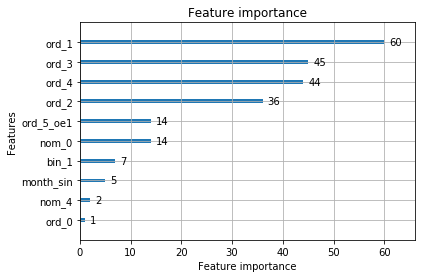

In [68]:
lgb.plot_importance(lgbm, max_num_features=20)

In [47]:
predict_proba_test = lgbm.predict(test)

In [46]:
predictions

array([0.44256557, 0.41891654, 0.34769219, ..., 0.38557377, 0.42924286,
       0.34710805])

In [54]:
#converting probabilities into 0 or 1
test_predictions = np.zeros(len(predict_proba_test))
for i in range(len(test_predictions)):
    if predict_proba_test[i]>=.5:       # setting threshold to .5
       test_predictions[i]=1
    else:  
       test_predictions[i]=0

In [64]:
submission = pd.DataFrame({'ID': test.id, 'TARGET':predict_proba_test})

In [66]:
submission.head()

,ID,TARGET
0,300000,0.442566
1,300001,0.418917
2,300002,0.347692
3,300003,0.439515
4,300004,0.529231


In [67]:
submission.to_csv("submission_lgb_v1.csv", index=False)

# Util

In [53]:
import matplotlib.gridspec as gridspec
def ploting_cat_fet(df, cols, vis_row=5, vis_col=2):
    
    grid = gridspec.GridSpec(vis_row,vis_col) # The grid of chart
    plt.figure(figsize=(17, 35)) # size of figure

    # loop to get column and the count of plots
    for n, col in enumerate(train[cols]): 
        tmp = pd.crosstab(train[col], train['target'], normalize='index') * 100
        tmp = tmp.reset_index()
        tmp.rename(columns={0:'No',1:'Yes'}, inplace=True)

        ax = plt.subplot(grid[n]) # feeding the figure of grid
        sns.countplot(x=col, data=train, order=list(tmp[col].values) , color='green') 
        ax.set_ylabel('Count', fontsize=15) # y axis label
        ax.set_title(f'{col} Distribution by Target', fontsize=18) # title label
        ax.set_xlabel(f'{col} values', fontsize=15) # x axis label

        # twinX - to build a second yaxis
        gt = ax.twinx()
        gt = sns.pointplot(x=col, y='Yes', data=tmp,
                           order=list(tmp[col].values),
                           color='black', legend=False)
        gt.set_ylim(tmp['Yes'].min()-5,tmp['Yes'].max()*1.1)
        gt.set_ylabel("Target %True(1)", fontsize=16)
        sizes=[] # Get highest values in y
        for p in ax.patches: # loop to all objects
            height = p.get_height()
            sizes.append(height)
            ax.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}%'.format(height/total*100),
                    ha="center", fontsize=14) 
        ax.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights


    plt.subplots_adjust(hspace = 0.5, wspace=.3)
    plt.show()

NameError: name 'total' is not defined

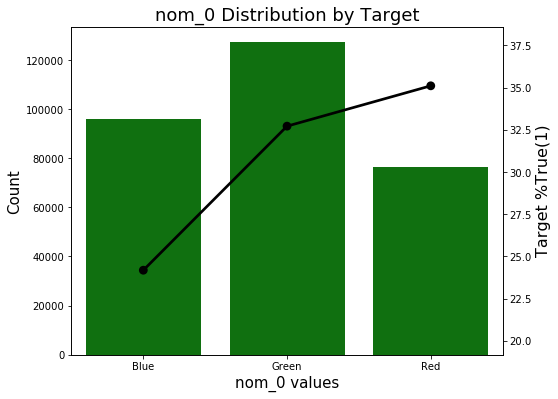

In [54]:
ploting_cat_fet(X_train, low_card, vis_row=5, vis_col=2)

In [46]:
from scipy import stats
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary